<a id="Geomedians_and_Geomedoids_top"></a>
# Geomedians and Geomedoids  
<hr>

## Background

This notebook is inspired by an IEEE publication titled [High-Dimensional Pixel Composites From
Earth Observation Time Series](http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8004469) authored by Dale Roberts, Norman Mueller, and Alexis McIntyre.  
  
This notebook explains geometric medians (geomedians) and geometric medoids (geomedoids) and applies these compositing methods to Landsat 7 imagery and displays a rendering of the computed composites.
<hr>

## Index

* [Import Dependencies and Connect to the Data Cube](#Geomedians_and_Geomedoids_import)
* [Choose Platform and Product](#Geomedians_and_Geomedoids_plat_prod)
* [Define the Extents of the Analysis](#Geomedians_and_Geomedoids_define_extents)
* [Load Data from the Data Cube](#Geomedians_and_Geomedoids_retrieve_data)
* [Geometric Medoid Compositing](#Geomedians_and_Geomedoids_medoid)
* [Geometric Median Compositing](#Geomedians_and_Geomedoids_median)

## <span id="Geomedians_and_Geomedoids_import">Import Dependencies and Connect to the Data Cube [&#9652;](#Geomedians_and_Geomedoids_top)</span>

In [1]:
import sys
import os
sys.path.append(os.environ.get('NOTEBOOK_ROOT'))

import matplotlib.pyplot as plt

from utils.data_cube_utilities.dc_display_map import display_map
from utils.data_cube_utilities.clean_mask import \
    landsat_qa_clean_mask, landsat_clean_mask_invalid
from utils.data_cube_utilities.dc_mosaic import \
    create_hdmedians_multiple_band_mosaic
from utils.data_cube_utilities.plotter_utils import figure_ratio

import datacube
dc = datacube.Datacube()

## <span id="Geomedians_and_Geomedoids_plat_prod">Choose Platform and Product [&#9652;](#Geomedians_and_Geomedoids_top)</span>

In [2]:
# Get available products
products_info = dc.list_products()

In [3]:
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


,platform,name
id,,
12,LANDSAT_7,ls7_collections_sr_scene
13,LANDSAT_7,ls7_ledaps_ghana
17,LANDSAT_7,ls7_ledaps_kenya
18,LANDSAT_7,ls7_ledaps_senegal
16,LANDSAT_7,ls7_ledaps_sierra_leone
19,LANDSAT_7,ls7_ledaps_tanzania
31,LANDSAT_7,ls7_ledaps_vietnam


**Choose the platform and product**

In [4]:
platform = 'LANDSAT_7'
product = 'ls7_ledaps_tanzania'

## <span id="Geomedians_and_Geomedoids_define_extents">Define the Extents of the Analysis [&#9652;](#Geomedians_and_Geomedoids_top)</span>

In [5]:
# Zanzibar, Tanzania
# lat = (-6.2238, -6.1267)
# lon = (39.2298, 39.2909)

# Masaki, Dar es Salaam, Tanzania
lat = (-6.7758, -6.7357)
lon = (39.2473, 39.2981)

time_range = ("2015-01-01", "2015-12-31")

In [6]:
display_map(latitude = lat, longitude = lon)  

## <span id="Geomedians_and_Geomedoids_retrieve_data">Load Data from the Data Cube [&#9652;](#Geomedians_and_Geomedoids_top)</span>

In [7]:
landsat_ds = \
    dc.load(product = product, platform = platform,
            lat = lat, lon = lon, time = time_range,
            measurements = ['red', 'green', 'nir', 'swir1', \
                            'swir2', 'blue', 'pixel_qa'],
            group_by='solar_day')

In [8]:
clean_mask = (landsat_qa_clean_mask(landsat_ds, platform) & 
              (landsat_ds != -9999).to_array().all('variable') & 
              landsat_clean_mask_invalid(landsat_ds))

In [9]:
landsat_ds = landsat_ds.where(clean_mask)

## <span id="Geomedians_and_Geomedoids_medoid">Geometric Medoid Compositing [&#9652;](#Geomedians_and_Geomedoids_top)</span>

> To compute a Geomedoid composite, the geometric medoid algorithm is applied to the time series of every pixel (indexed by `lat,lon`).  
Every pixel (indexed by `time,lat,lon`) in the the time series is treated as an independent observation used in the computation of the geometric medoid.  
  
> In the case of Landsat 7 imagery, an observation `<red,green,blue,nir,swir1,swir2>` is a vector/point embedded in 6-dimensional feature-space. 

> ### Formal Definition of a  Geometric Medoid  
>Given a finite set $\mathbb{X}$ of $\mathbb{_p}$-dimensional observation vectors $\mathbb{X} = \{x_1,...,x_n \}$ , the medoid  of these observations is given by the following equation <sup>[[1]](#hd_medians)</sup>: 
  
>$$ m := argmin_{ x \in \mathbb{X}} \sum_{i=1}^{n}{ \lVert x - x_i\rVert }   $$

> We use the `create_hdmedians_multiple_band_mosaic()` function with the setting `operation='medoid'` to create a geomedoid composite. This function comes from `utils.data_cube_utilities.dc_mosaic`.

**Run geomedoid compositor**

In [10]:
geomedoid_mosaic = \
    create_hdmedians_multiple_band_mosaic(landsat_ds,
                                          clean_mask = clean_mask,
                                          operation = 'medoid')

> ### Example of a composited `swir1` band

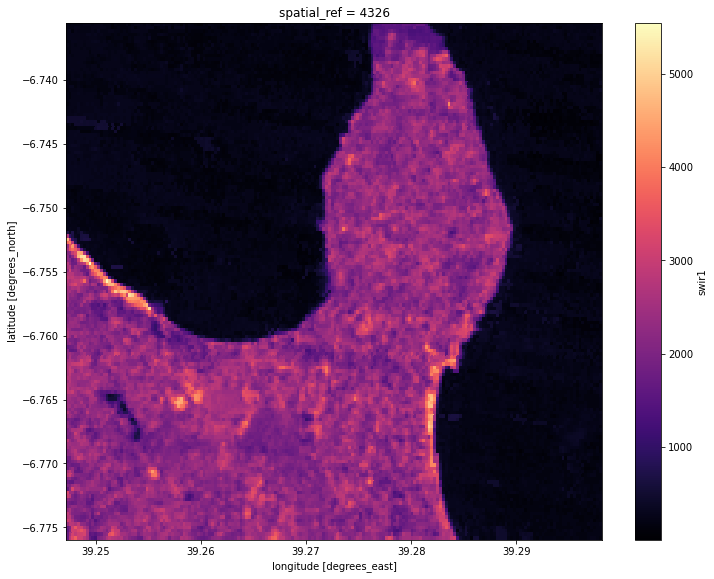

In [11]:
figsize = figure_ratio(landsat_ds, fixed_width=12)
geomedoid_mosaic.swir1.plot(figsize = figsize, cmap = 'magma')
plt.show()

## <span id="Geomedians_and_Geomedoids_median">Geometric Median Compositing [&#9652;](#Geomedians_and_Geomedoids_top)</span>

> To compute a Geomedian composite, the geometric median algorithm is applied to the time series of every pixel (indexed by `lat,lon`).  
Every pixel (indexed by `time,lat,lon`) in the the time series is treated as an independent observation used in the computation of the geometric median.  
  
> In the case of Landsat 7 imagery an observation `<red,green,blue,nir,swir1,swir2>` is a vector/point embedded in 6-dimensional feature-space. 

> ### Formal Definition of a  Geometric Median  
>Given a finite set $\mathbb{X}$ of $\mathbb{_p}$-dimensional observation vectors $\mathbb{X} = \{ x_1,...,x_n \}$ , the Median  of these observations is given by the following equation <sup>[[1]](#hd_medians)</sup>: 
  
>$$ \hat{\mu} := argmin_{ x \in \mathbb{R^{_p}}} \sum_{i=1}^{n}{ \lVert x - x_i\rVert }   $$
  
> **Note:**  
> There is a subtle difference between the definition of the geometric median and the medoid: the search space for the solution differs and has the effect that the medoid returns one of the true observations whereas the geometric median can be described as a synthetic (not physically observed) observation.<sup>[[2]](#multi_dim_medians)</sup> 

> We use the `create_hdmedians_multiple_band_mosaic()` function with the setting `operation='median'` to create a geomedian composite. Note that `operation='median'` is the default setting, so this can be omitted for geomedians. This function comes from `utils.data_cube_utilities.dc_mosaic`.

**Run geomedian compositor**

In [12]:
geomedian_mosaic = \
    create_hdmedians_multiple_band_mosaic(landsat_ds,
                                          clean_mask = clean_mask,
                                          operation = 'median')

> ### Example of a composited `swir1` band

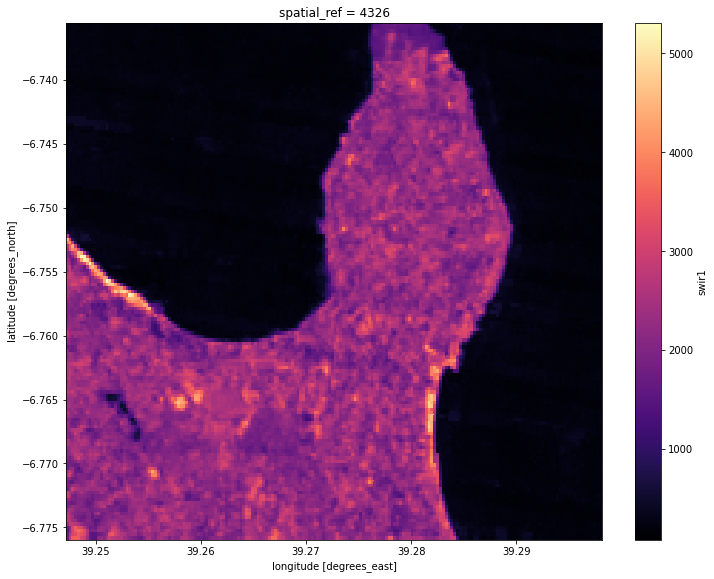

In [13]:
figsize = figure_ratio(landsat_ds, fixed_width=12)
geomedian_mosaic.swir1.plot(figsize = figsize, cmap = 'magma')
plt.show()

----   
# References   

<span id='hd_medians'></span>
1. Dale Roberts 2018. Hdmedians. Github: https://github.com/daleroberts/hdmedians,  
<span id='multi_dim_medians'></span>
2. Small, C. G. (1990). A survey of multidimensional medians. International Statistical Review/Revue Internationale de Statistique, 263-277.